In [1]:
import IBS_SN_IL as ibs
import numpy as np
from numpy import sqrt, sin, cos, fabs, cbrt, pi,log
from scipy.optimize import bisect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 34,'legend.fontsize':22})
plt.rcParams["text.usetex"] =True
import sys
import figure_arrange_scripts as ff
import os.path as path
import os

# Reading the beta functions and dispersion functions file

In [2]:
with open("IOTA_1NL_100MeV_v8.4.8_und.6ds_lattice_for_IBS_calculations_v2.txt") as f:
    content = f.readlines()
content = [x.strip() for x in content]
content = content[1:]
data = [[float(x) for x in line.split()] for line in content]
z = []      
bet_x = []
bet_y = []
D_x = []
Dp_x = []
Phi_x = []
sgm_x = []
sgm_y = []
for line in data:
    N,s,betx,alphx,bety,alphy,Dx,Dpx,Dy,Dpy = line
    z.append(s)
    bet_x.append(betx)
    bet_y.append(bety) 
    D_x.append(Dx)
    Dp_x.append(Dpx)
    Phi_x.append(Dx*alphx/betx+Dpx)
#dz array definition
dz = z[1]-z[0]
dz_arr = len(z)*[dz]

# Calculating pre-factor A in cm/s

In [3]:
c_light = 2.99792458e10#cm/s
me = 0.511#MeV
re = 2.817941e-13#cm
Ee  = 100#MeV
gamma = Ee/me
beta = np.sqrt(1-1/gamma**2)
L  = 4000#cm
f0 = 7.5e6#Hz
e = 1.602e-19#C
Ibeam = 1.3#mA
Nb = Ibeam*1e-3/e/f0
Aibs = c_light*Nb*re**2/12/pi/beta**3/gamma**5/L#1/cm

# Calculating sgmp from Vrf at a given sgms

In [4]:
alpha = 0.07679
q=4
Vrf = 350#V
etas = alpha-1/gamma**2
f = 30e6#Hz
sgms_0 = 38#cm
sgmp_rf = sgms_0/c_light*f*2*pi*sqrt(Vrf/(2*pi*Ee*1e6*beta**2*q*fabs(etas))) 
print('sgmp predicted through Vrf = {:.3e}'.format(sgmp_rf))

sgmp predicted through Vrf = 3.218e-04


# Synchrotron radiation decrements

In [5]:
SR_dec = np.array([0.336,
                   0.852,
                   2.22])#1/s
dec_x = SR_dec[0]
dec_p = SR_dec[2]

# IBS increments at given emx, emy, sgms, sgmsp

In [6]:
emx = 0.3e-4#2.467221337540153e-05#cm
em_ratio = 0.01
emy = em_ratio*emx#1.6576776816057589e-07#cm
sgms = sgms_0
sgmp = sgmp_rf

rates = ibs.CalcRelRates(Aibs,re,gamma,emx,emy,sgms,sgmp,dz_arr,bet_x,D_x,Phi_x,bet_y)
for r in rates:
    print('{:.3f}'.format(r))

0.397
0.001
2.178


# Finding the best fit at $I_{\mathrm{beam}}$ = 1.3 mA

In [7]:
sgmp0 = 8.426e-5 #from equilibrium between quantum fluctuations and radiation damping, no IBS
def CalcRelIBSRatesExSgmpSgms(ex,sgmp,sgms,Ib):
    ey = em_ratio*ex
    rates = ibs.CalcRelRates(Aibs*Ib/Ibeam,re,gamma,ex,ey,sgms,sgmp,dz_arr,bet_x,D_x,Phi_x,bet_y)
    return rates[0],rates[2]

In [8]:
CalcRelIBSRatesExSgmpSgms(0.3e-4,3e-4,40,Ibeam)#test

(0.3855787891059237, 2.402480365967599)

In [9]:
def discrepancy(ex_sgmp,sgms_Ib):
    ex,sgmp = ex_sgmp
    sgms,Ib = sgms_Ib
    inc_x,inc_p = CalcRelIBSRatesExSgmpSgms(ex,sgmp,sgms,Ib)
    aux_coef = sgmp**2/(sgmp**2-sgmp0**2)
    return sqrt(((inc_x-dec_x)/dec_x)**2+((inc_p*aux_coef-dec_p)/dec_p)**2)

In [8]:
from scipy.optimize import minimize

In [11]:
sgms = 38#cm
ex_sgmp_guess = [0.3e-4,3e-4]
sgms_Ib = [sgms,Ibeam]
res = minimize(discrepancy,ex_sgmp_guess,sgms_Ib)
print(res)
emx_fit,sgmp_fit = res.x

      fun: 0.0001090108378898311
 hess_inv: array([[ 1.27294405e-12, -6.53635703e-12],
       [-6.53635703e-12,  4.02901961e-11]])
      jac: array([68718.6224637 ,  2980.03225237])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 432
      nit: 10
     njev: 105
   status: 2
  success: False
        x: array([3.23993064e-05, 3.14495416e-04])


In [12]:
discrepancy([emx_fit,sgmp_fit],sgms_Ib)

0.0001090108378898311

# Finding $\epsilon_x$,$\sigma_p$,$\sigma_x$ as functions of $I_{\mathrm{beam}}$

In [17]:
emy = em_ratio*emx_fit
undbetaX = 182.0819140305466#cm
undbetaY = 175.30651828812663#cm
sgmy = sqrt(undbetaY*emy)#cm
undDx = 87.05741489#cm
Imax = 10965988.52561267/3.5e6*1.3#mA
Ib_arr =np.concatenate( (np.linspace(Ibeam/2,Ibeam/2,1),np.linspace(Ibeam,Imax,5)),axis=0)
ex_arr = []
sgmp_arr = []
sx_und_arr = []
ex_sgmp_guess = [0.2e-4,3e-4]

for Ib in Ib_arr:    
    sgms_Ib = [sgms,Ib]
    res = minimize(discrepancy,ex_sgmp_guess,sgms_Ib)
    print('fun: ',res.fun)
    print('x: ',res.x)
    ex,sgmp = res.x
    ex_arr.append(ex)
    sgmp_arr.append(sgmp)
    sx_und_arr.append(sqrt(ex*undbetaX+undDx**2*sgmp**2) )
    ex_sgmp_guess = [1.05*ex,1.05*sgmp]

fun:  0.0006621153457284903
x:  [2.42950128e-05 2.75753113e-04]
fun:  0.0006640422564018638
x:  [3.23910813e-05 3.14578453e-04]
fun:  0.0005692353379163188
x:  [3.86757658e-05 3.41503033e-04]
fun:  0.0005349560340536169
x:  [4.3768830e-05 3.6186807e-04]
fun:  0.00046497641858014816
x:  [4.81367015e-05 3.78419020e-04]
fun:  0.00045334084136575977
x:  [5.20011646e-05 3.92548603e-04]


In [35]:
# np.save('Ib_arr',Ib_arr)
# np.save('ex_arr',ex_arr)
# np.save('sgmp_arr',sgmp_arr)
# np.save('sx_und_arr',sx_und_arr)

In [12]:
Ib_arr = np.load('Ib_arr.npy')
ex_arr = np.load('ex_arr.npy')
sgmp_arr = np.load('sgmp_arr.npy')
sx_und_arr = np.load('sx_und_arr.npy')

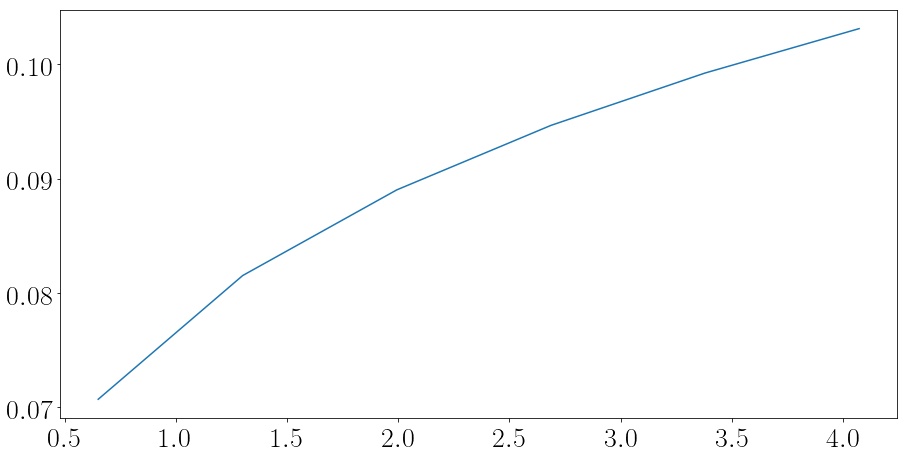

In [13]:
plt.plot(Ib_arr,sx_und_arr)
# plt.xlabel('Ibeam, mA')
# plt.ylabel('sigma_x, cm')
plt.show()

In [14]:
# a = np.transpose(np.asarray([[3.5e6/1.3*i for i in Ib_arr],[1e4*sx for sx in sx_und_arr],[sgmy*1e4 for sx in sx_und_arr]]))
# np.savetxt("ex_data_38.csv", a, delimiter=",")

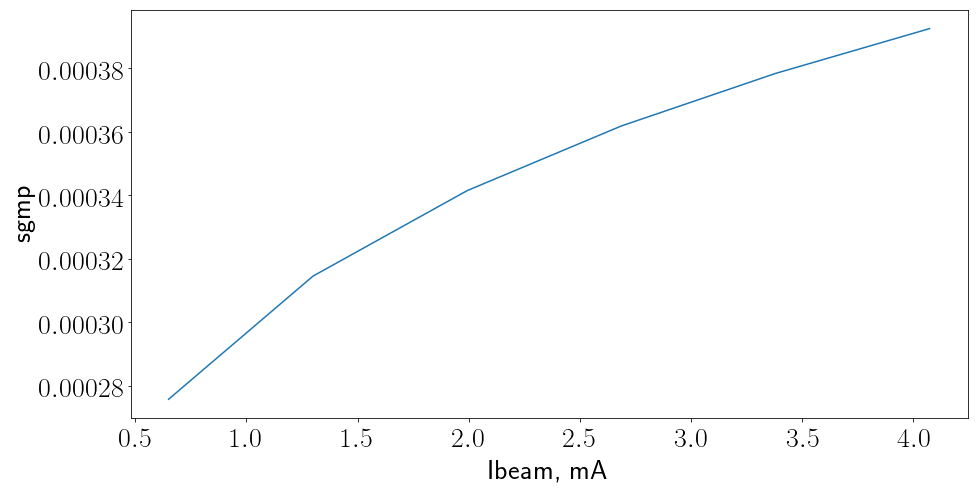

In [15]:
plt.plot(Ib_arr,sgmp_arr)
plt.xlabel('Ibeam, mA')
plt.ylabel('sgmp')
plt.show()

In [16]:
ibs_i_list = np.asarray(Ib_arr)
ibs_sgmp_list = np.asarray(sgmp_arr)
ibs_ex_list = 1e4*np.asarray(ex_arr)
from scipy.interpolate import interp1d
ibs_ex = interp1d(ibs_i_list,ibs_ex_list,kind='cubic')
ibs_sgmp = interp1d(ibs_i_list,ibs_sgmp_list,kind = 'cubic')

In [17]:
0.095*ibs_ex(1.3)

0.030771527262712782

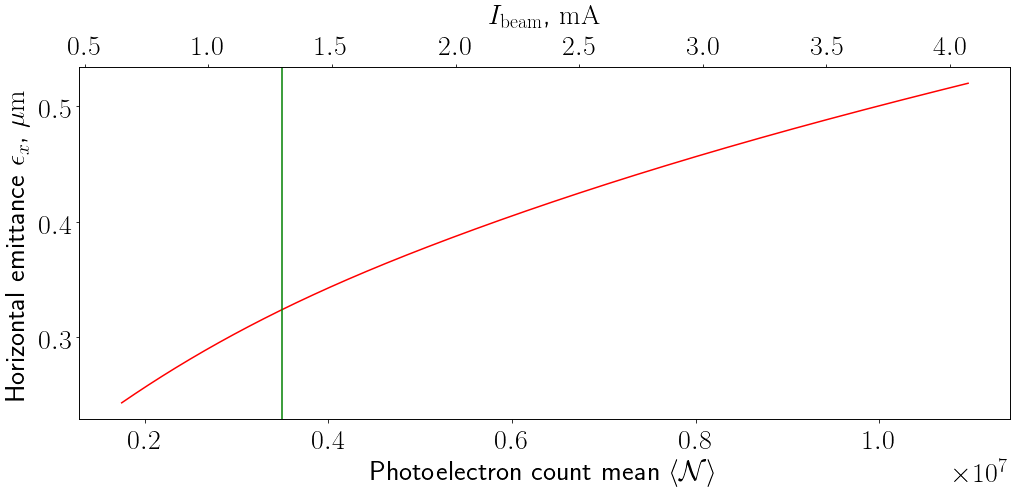

In [18]:
i_measured = 1.3#mA
N_measured = 3.5e6
i_to_N = N_measured/i_measured
i_min = min(ibs_i_list)
i_max = max(ibs_i_list)
N_min=i_to_N*i_min
N_max = i_to_N*i_max
ibs_i_interp_list = np.linspace(i_min,i_max,1000)
ibs_N_interp_list = i_to_N*ibs_i_interp_list#[i_to_N*i for i in ibs_i_interp_list]
ibs_ex_interp_list = ibs_ex(ibs_i_interp_list)

fig, ax1 = plt.subplots()
#plt.title('Sample waveform for undulator radiation in IOTA')
#color = 'tab:red'
ax1.set_xlabel(r'Photoelectron count mean $\langle\mathcal{N}\rangle$')
ax1.set_ylabel(r'Horizontal emittance $\epsilon_x$, $\mu\mathrm{m}$')
ax1.plot(ibs_N_interp_list,ibs_ex_interp_list,color='red')#,label='Simulation')
#ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(N_measured,color='green')

ex_measured = 0.2467221337540153
ey_measured = 0.001657677681605759
em_ratio = ey_measured/ex_measured


ex_interp_meas  = ibs_ex(i_measured)
rescaled_ex =  ex_measured/ex_interp_meas*ibs_ex_interp_list
#ax1.plot(ibs_N_interp_list,rescaled_ex,color='blue',linestyle='--', label='Rescaled simulation')
# ax1.errorbar([N_measured],[ibs_ex(i_measured)],yerr=0.0*ex_measured,marker='D',color='orange',markersize=10,
#              label='Measurement of $\epsilon_y/\epsilon_x$ @1.3 mA')
#ax1.set_xlim(0,1.02*max(ibs_N_interp_list))
#ax1.set_yscale('log')
#ax1.set_ylim(3e-2,1.05*max(ibs_ex_interp_list))
#ex0 = 3.567e-2#microns
#ax1.axhline(ex0)
#ey0 = emy*1e4
#ax1.axhline(ey0)


ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
ax2.set_xlabel(r'$I_\mathrm{beam}$, $\mathrm{mA}$')  # we already handled the x-label with ax1
#ax2.tick_params(axis='x', labelcolor=color)
ax1min,ax1max = ax1.get_xlim()
ax2.set_xlim(ax1min/i_to_N,ax1max/i_to_N)
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('ex.png',dpi=300, bbox_inches='tight')
plt.show()

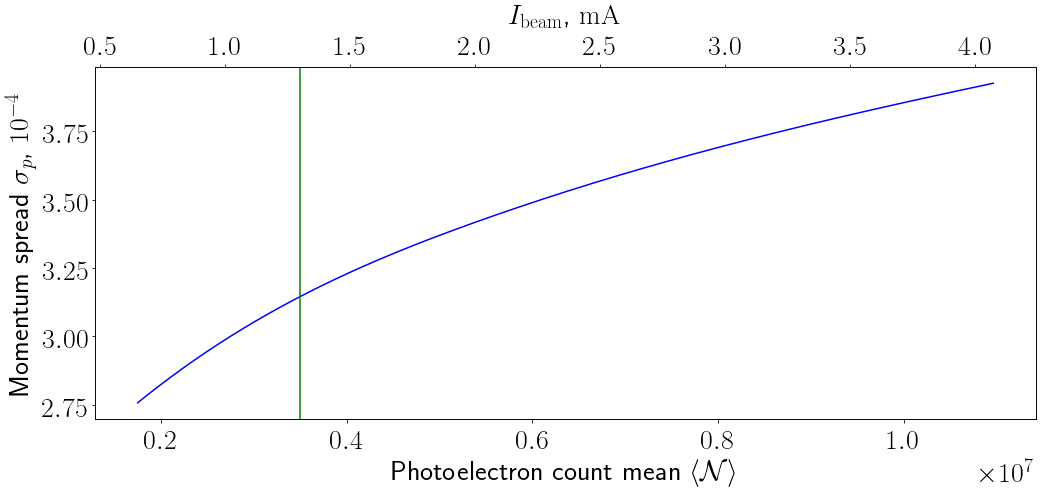

In [19]:
i_measured = 1.3#mA
N_measured = 3.5e6
i_to_N = N_measured/i_measured
i_min = min(ibs_i_list)
i_max = max(ibs_i_list)
N_min=i_to_N*i_min
N_max = i_to_N*i_max
ibs_i_interp_list = np.linspace(i_min,i_max,1000)
ibs_N_interp_list = i_to_N*ibs_i_interp_list#[i_to_N*i for i in ibs_i_interp_list]
ibs_sgmp_interp_list = ibs_sgmp(ibs_i_interp_list)

fig, ax1 = plt.subplots()
#plt.title('Sample waveform for undulator radiation in IOTA')
#color = 'tab:red'
ax1.set_xlabel(r'Photoelectron count mean $\langle\mathcal{N}\rangle$')
ax1.set_ylabel(r'Momentum spread  $\sigma_p$, $10^{-4}$')
ax1.plot(ibs_N_interp_list,1e4*ibs_sgmp_interp_list,color='blue')#,label='Simulation')
#ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(N_measured,color='green')


ex_measured = 0.2467221337540153
ey_measured = 0.001657677681605759
em_ratio = ey_measured/ex_measured


ex_interp_meas  = ibs_ex(i_measured)
rescaled_ex =  ex_measured/ex_interp_meas*ibs_ex_interp_list
#ax1.plot(ibs_N_interp_list,rescaled_ex,color='blue',linestyle='--', label='Rescaled simulation')
# ax1.errorbar([N_measured],[1e4*ibs_sgmp(i_measured)],yerr=0.0*ex_measured,marker='D',color='orange',markersize=10,
#              label='Measurement of $\epsilon_y/\epsilon_x$ @1.3 mA')
#ax1.set_xlim(0,1.02*max(ibs_N_interp_list))
#ax1.set_yscale('log')
#ax1.set_ylim(3e-2,1.05*max(ibs_ex_interp_list))
#ex0 = 3.567e-2#microns
#ax1.axhline(ex0)
#ey0 = emy*1e4
#ax1.axhline(ey0)


ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
ax2.set_xlabel(r'$I_\mathrm{beam}$, $\mathrm{mA}$')  # we already handled the x-label with ax1
#ax2.tick_params(axis='x', labelcolor=color)
ax1min,ax1max = ax1.get_xlim()
ax2.set_xlim(ax1min/i_to_N,ax1max/i_to_N)
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('sgmp.png',dpi=300, bbox_inches='tight')
plt.show()

# Double figure for PRAB paper

Result saved to G:\My Drive\UHCICAGO\Thesis\Theory\Valeri's_idea\Experimetnal_data\IBS_simulationsm\Python_IBS_Code\..\..\..\PRAB_paper\ex_sgmp.png


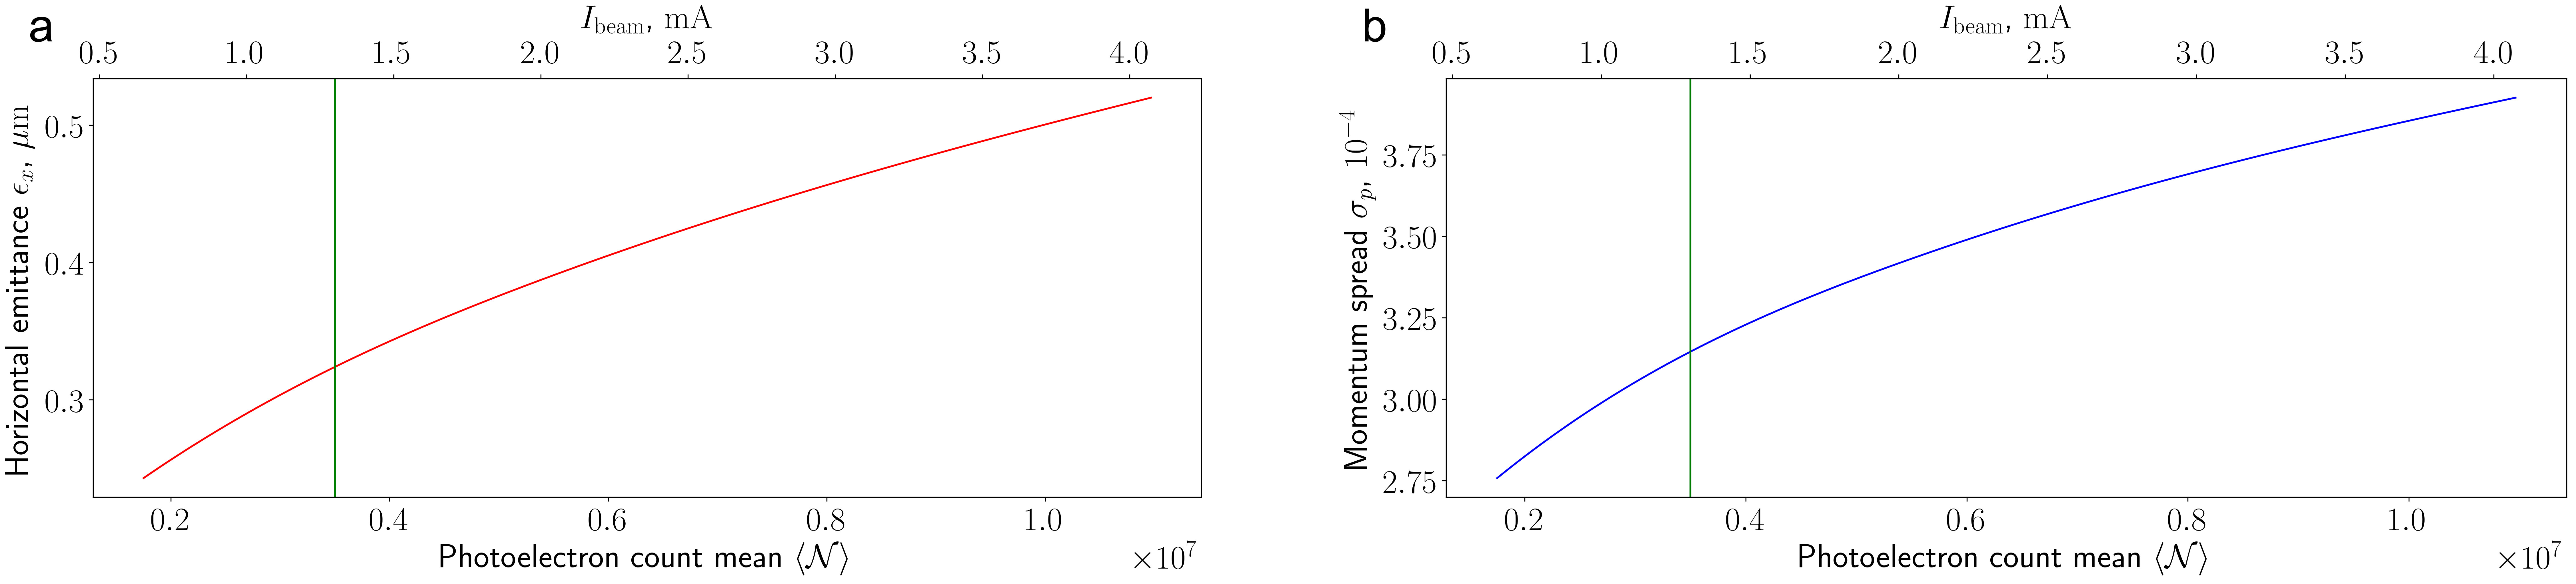

In [20]:
im_paths = ['ex.png','sgmp.png']
hor_separ = 0.05
label_pos_x = 100
v_space = 0
fontsize = 160
output_path = path.join(os.getcwd(),'..','..','..','PRAB_paper','ex_sgmp.png')
ff.RowOfFigures(im_paths,output_path,hor_separ,v_space,fontsize,label_pos_x,display_inline=1)

In [21]:
0.38/3e8

1.2666666666666666e-09

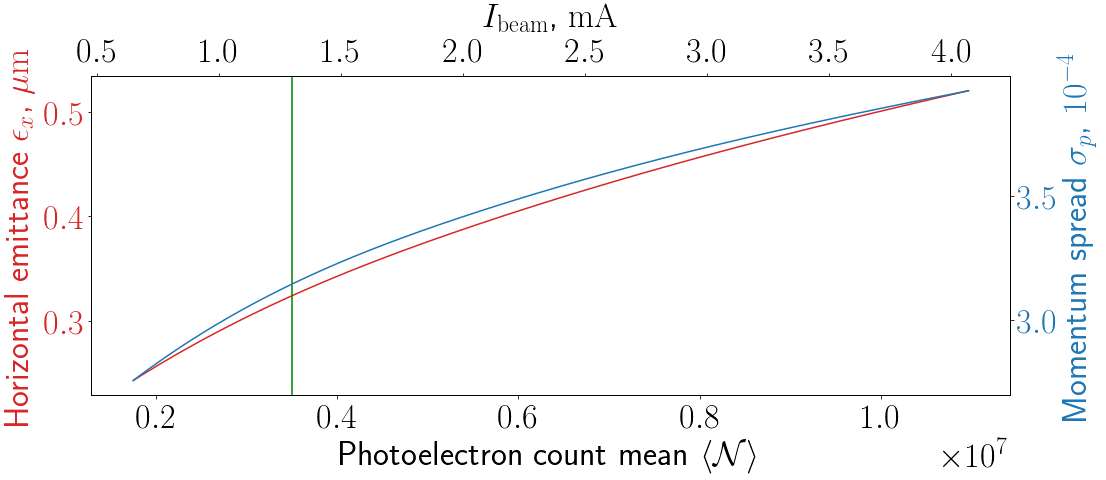

In [28]:
i_measured = 1.3#mA
N_measured = 3.5e6
i_to_N = N_measured/i_measured
i_min = min(ibs_i_list)
i_max = max(ibs_i_list)
N_min=i_to_N*i_min
N_max = i_to_N*i_max
ibs_i_interp_list = np.linspace(i_min,i_max,1000)
ibs_N_interp_list = i_to_N*ibs_i_interp_list#[i_to_N*i for i in ibs_i_interp_list]
ibs_ex_interp_list = ibs_ex(ibs_i_interp_list)

fig, ax1 = plt.subplots()
#plt.title('Sample waveform for undulator radiation in IOTA')
#color = 'tab:red'
ax1.set_xlabel(r'Photoelectron count mean $\langle\mathcal{N}\rangle$')
color='tab:red'
ax1.set_ylabel(r'Horizontal emittance $\epsilon_x$, $\mu\mathrm{m}$',color=color)
ax1.plot(ibs_N_interp_list,ibs_ex_interp_list,color=color)#,label='Simulation')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(N_measured,color='green')

ex_measured = 0.2467221337540153
ey_measured = 0.001657677681605759
em_ratio = ey_measured/ex_measured


ex_interp_meas  = ibs_ex(i_measured)
rescaled_ex =  ex_measured/ex_interp_meas*ibs_ex_interp_list
#ax1.plot(ibs_N_interp_list,rescaled_ex,color='blue',linestyle='--', label='Rescaled simulation')
# ax1.errorbar([N_measured],[ibs_ex(i_measured)],yerr=0.0*ex_measured,marker='D',color='orange',markersize=10,
#              label='Measurement of $\epsilon_y/\epsilon_x$ @1.3 mA')
#ax1.set_xlim(0,1.02*max(ibs_N_interp_list))
#ax1.set_yscale('log')
#ax1.set_ylim(3e-2,1.05*max(ibs_ex_interp_list))
#ex0 = 3.567e-2#microns
#ax1.axhline(ex0)
#ey0 = emy*1e4
#ax1.axhline(ey0)


ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
ax2.set_xlabel(r'$I_\mathrm{beam}$, $\mathrm{mA}$')  # we already handled the x-label with ax1
#ax2.tick_params(axis='x', labelcolor=color)
ax1min,ax1max = ax1.get_xlim()
ax2.set_xlim(ax1min/i_to_N,ax1max/i_to_N)
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, labels)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel(r'Momentum spread  $\sigma_p$, $10^{-4}$',color=color)
ax3.plot(ibs_N_interp_list,1e4*ibs_sgmp_interp_list,color=color)#,label='Simulation')
ax3.tick_params(axis='y', labelcolor=color)
plt.savefig(path.join(os.getcwd(),'..','..','..','PRAB_paper','ex_sgmp.png'),dpi=300, bbox_inches='tight')
plt.show()

In [1]:
3.5e6/1.3e-3*7.5e6*1.62e-19

0.0032711538461538464